In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from tensorflow.keras.regularizers import l2

# Define paths and parameters
DATASET_PATH = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MFCC = 13  # Number of MFCC coefficients
HOP_LENGTH = 512  # Hop length for MFCC extraction
WIN_LENGTH = 1024  # Window length for MFCC extraction

labels = {}
with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract MFCC features using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

    # Ensure all MFCC features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]

    X.append(mfcc)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [10]:
from sklearn.model_selection import train_test_split

# Data augmentation using audiomentations
augment = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
])

X_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X]

# Split the data into training (80%) and the rest (20%)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the rest into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}

# Define and compile a CNN model with L2 regularization and other improvements
model = tf.keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
           kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using class weights
history = model.fit(np.expand_dims(X_train, -1), y_train, batch_size=32, epochs=30,
                    validation_data=(np.expand_dims(X_val, -1), y_val), class_weight=class_weight_dict)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(np.expand_dims(X_val, -1), y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(np.expand_dims(X_test, -1), y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the trained model
model.save("speaker_verification_model.h5")

Epoch 1/30


635/635 [==============================] - 5s 7ms/step - loss: 2.0682 - accuracy: 0.8507 - val_loss: 1.6497 - val_accuracy: 0.7912
Epoch 2/30
635/635 [==============================] - 4s 7ms/step - loss: 0.9515 - accuracy: 0.9053 - val_loss: 0.6577 - val_accuracy: 0.9724
Epoch 3/30
635/635 [==============================] - 4s 7ms/step - loss: 0.6275 - accuracy: 0.9235 - val_loss: 0.5250 - val_accuracy: 0.9224
Epoch 4/30
635/635 [==============================] - 4s 7ms/step - loss: 0.4314 - accuracy: 0.9355 - val_loss: 0.3267 - val_accuracy: 0.9555
Epoch 5/30
635/635 [==============================] - 4s 7ms/step - loss: 0.3249 - accuracy: 0.9458 - val_loss: 0.2081 - val_accuracy: 0.9815
Epoch 6/30
635/635 [==============================] - 4s 7ms/step - loss: 0.2860 - accuracy: 0.9442 - val_loss: 0.2300 - val_accuracy: 0.9665
Epoch 7/30
635/635 [==============================] - 4s 7ms/step - loss: 0.2585 - accuracy: 0.9502 - val_loss: 0.2090 - val_accuracy: 0.9665
Epoch 8/30
635/63

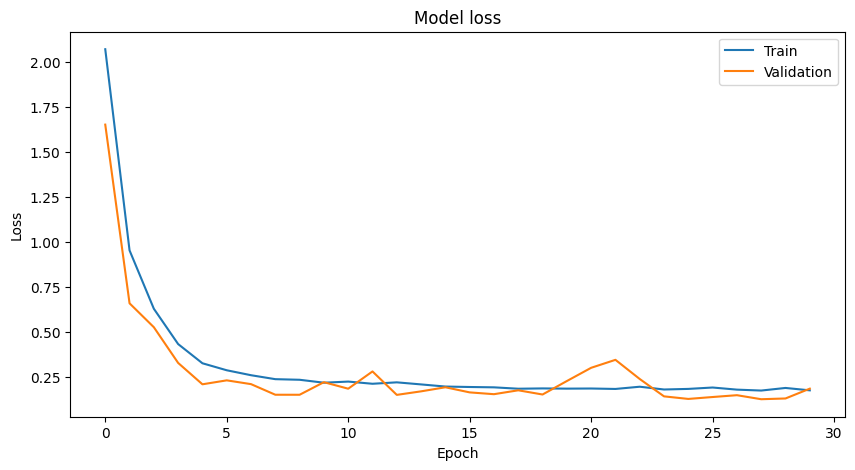

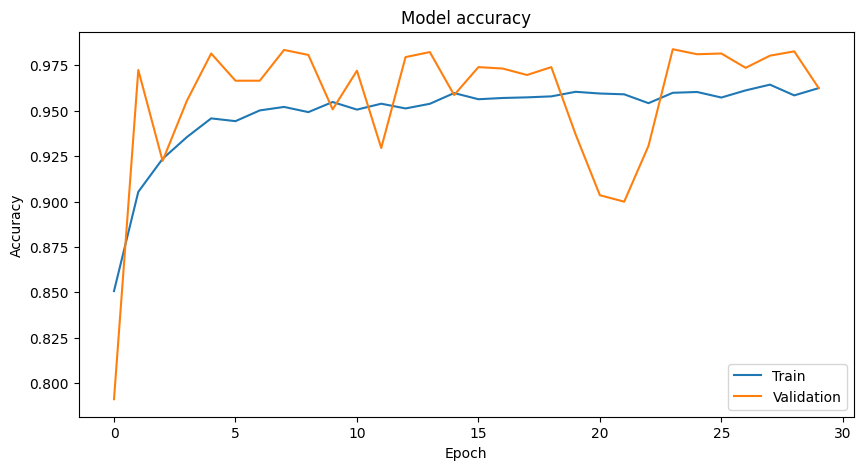

: 

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [8]:
# Evaluate the model on the pseudo-test set
pseudo_test_loss, pseudo_test_accuracy = model.evaluate(np.expand_dims(X_val, -1), y_val)
print(f"Pseudo Test Loss: {pseudo_test_loss}")
print(f"Pseudo Test Accuracy: {pseudo_test_accuracy}")

159/159 [==============================] - 1s 4ms/step - loss: 0.1273 - accuracy: 0.9803
Pseudo Test Loss: 0.12726743519306183
Pseudo Test Accuracy: 0.9802994728088379
